# Lab 1 Analysis Example using Thicket

In [100]:
import sys
sys.path.append("/scratch/group/csce435-f23/python-3.8.17/lib/python3.8/site-packages")
sys.path.append("/scratch/group/csce435-f23/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [101]:
tk = th.Thicket.from_caliperreader(glob("/home/kdai/project/cuda/cuda_naive/*.cali"))
# tk = th.Thicket.from_caliperreader(glob("/home/kdai/project/cpu/mpi_naive/*.cali"))

In [ ]:
# Performance data
tk.dataframe

Groupby matrix size argument, available in the metadata (tk.metadata) to organize our performance data into 3 groupings.

In [ ]:
tk.metadata

In [104]:
gb = tk.groupby("num_threads")

6  thickets created...
{1: <thicket.thicket.Thicket object at 0x2b2aec74b040>, 2: <thicket.thicket.Thicket object at 0x2b2ae4d6a940>, 4: <thicket.thicket.Thicket object at 0x2b2ae4d3eca0>, 8: <thicket.thicket.Thicket object at 0x2b2ae7ed5490>, 16: <thicket.thicket.Thicket object at 0x2b2aec3de340>, 32: <thicket.thicket.Thicket object at 0x2b2aec67bd30>}


Compose these 3 groups column-wise to get a holistic view of the data

ctk = th.Thicket.concat_thickets(
    thickets=list(gb.values()),
    headers=list(gb.keys()),
    axis="columns",
    metadata_key="num_procs"
)

Perform pandas operations to get the table in a desirable format for plotting

In [124]:
ctk = th.Thicket.concat_thickets(
    thickets=list(gb.values()),
    headers=list(gb.keys()),
    axis="columns",
    metadata_key="InputSize"
)

# Drop unwanted columns
array = [("node","")]
for i in (1,2,4,8,16,32):
    array.append((i,"nid"))
    array.append((i,"spot.channel"))
    
    #comment out the one you want to plot
    array.append((i, 'Min time/rank'))
    array.append((i, 'Max time/rank'))
#     array.append((i, 'Avg time/rank'))
    array.append((i, 'Total time'))
    array.append((i, 'Avg GPU time/rank'))
    array.append((i, 'Min GPU time/rank'))
    array.append((i, 'Max GPU time/rank'))
    array.append((i, 'Max GPU time/rank'))
    array.append((i, 'Total GPU time'))

ctk.dataframe = ctk.dataframe.reset_index().drop(array, axis=1)
# Rename index to remove tuple
ctk.dataframe = ctk.dataframe.rename({("name", ""): "name", ("InputSize", ""): "InputSize"}).set_index(["name", "InputSize"])
# Drop "time" label as it is redundant
# ctk.dataframe.columns = ctk.dataframe.columns.droplevel(1)

In [125]:
ctk.dataframe.columns

MultiIndex([( 1, 'Avg time/rank'),
            ( 2, 'Avg time/rank'),
            ( 4, 'Avg time/rank'),
            ( 8, 'Avg time/rank'),
            (16, 'Avg time/rank'),
            (32, 'Avg time/rank')],
           )

In [ ]:
ctk.dataframe

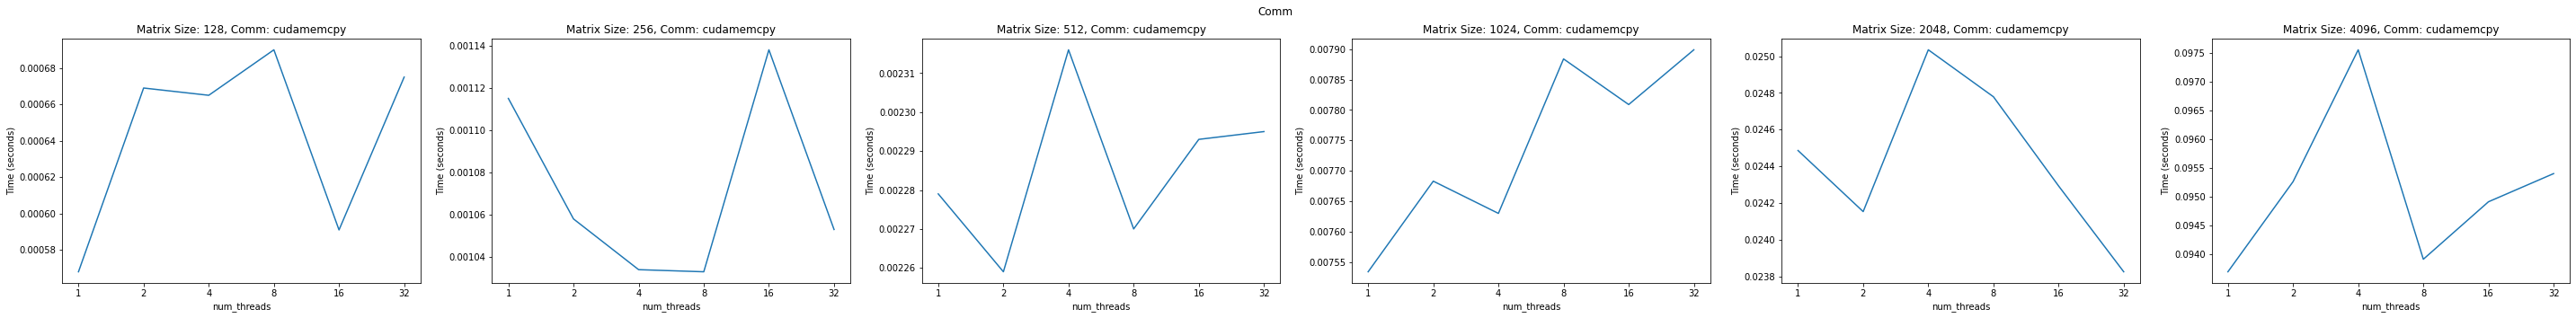

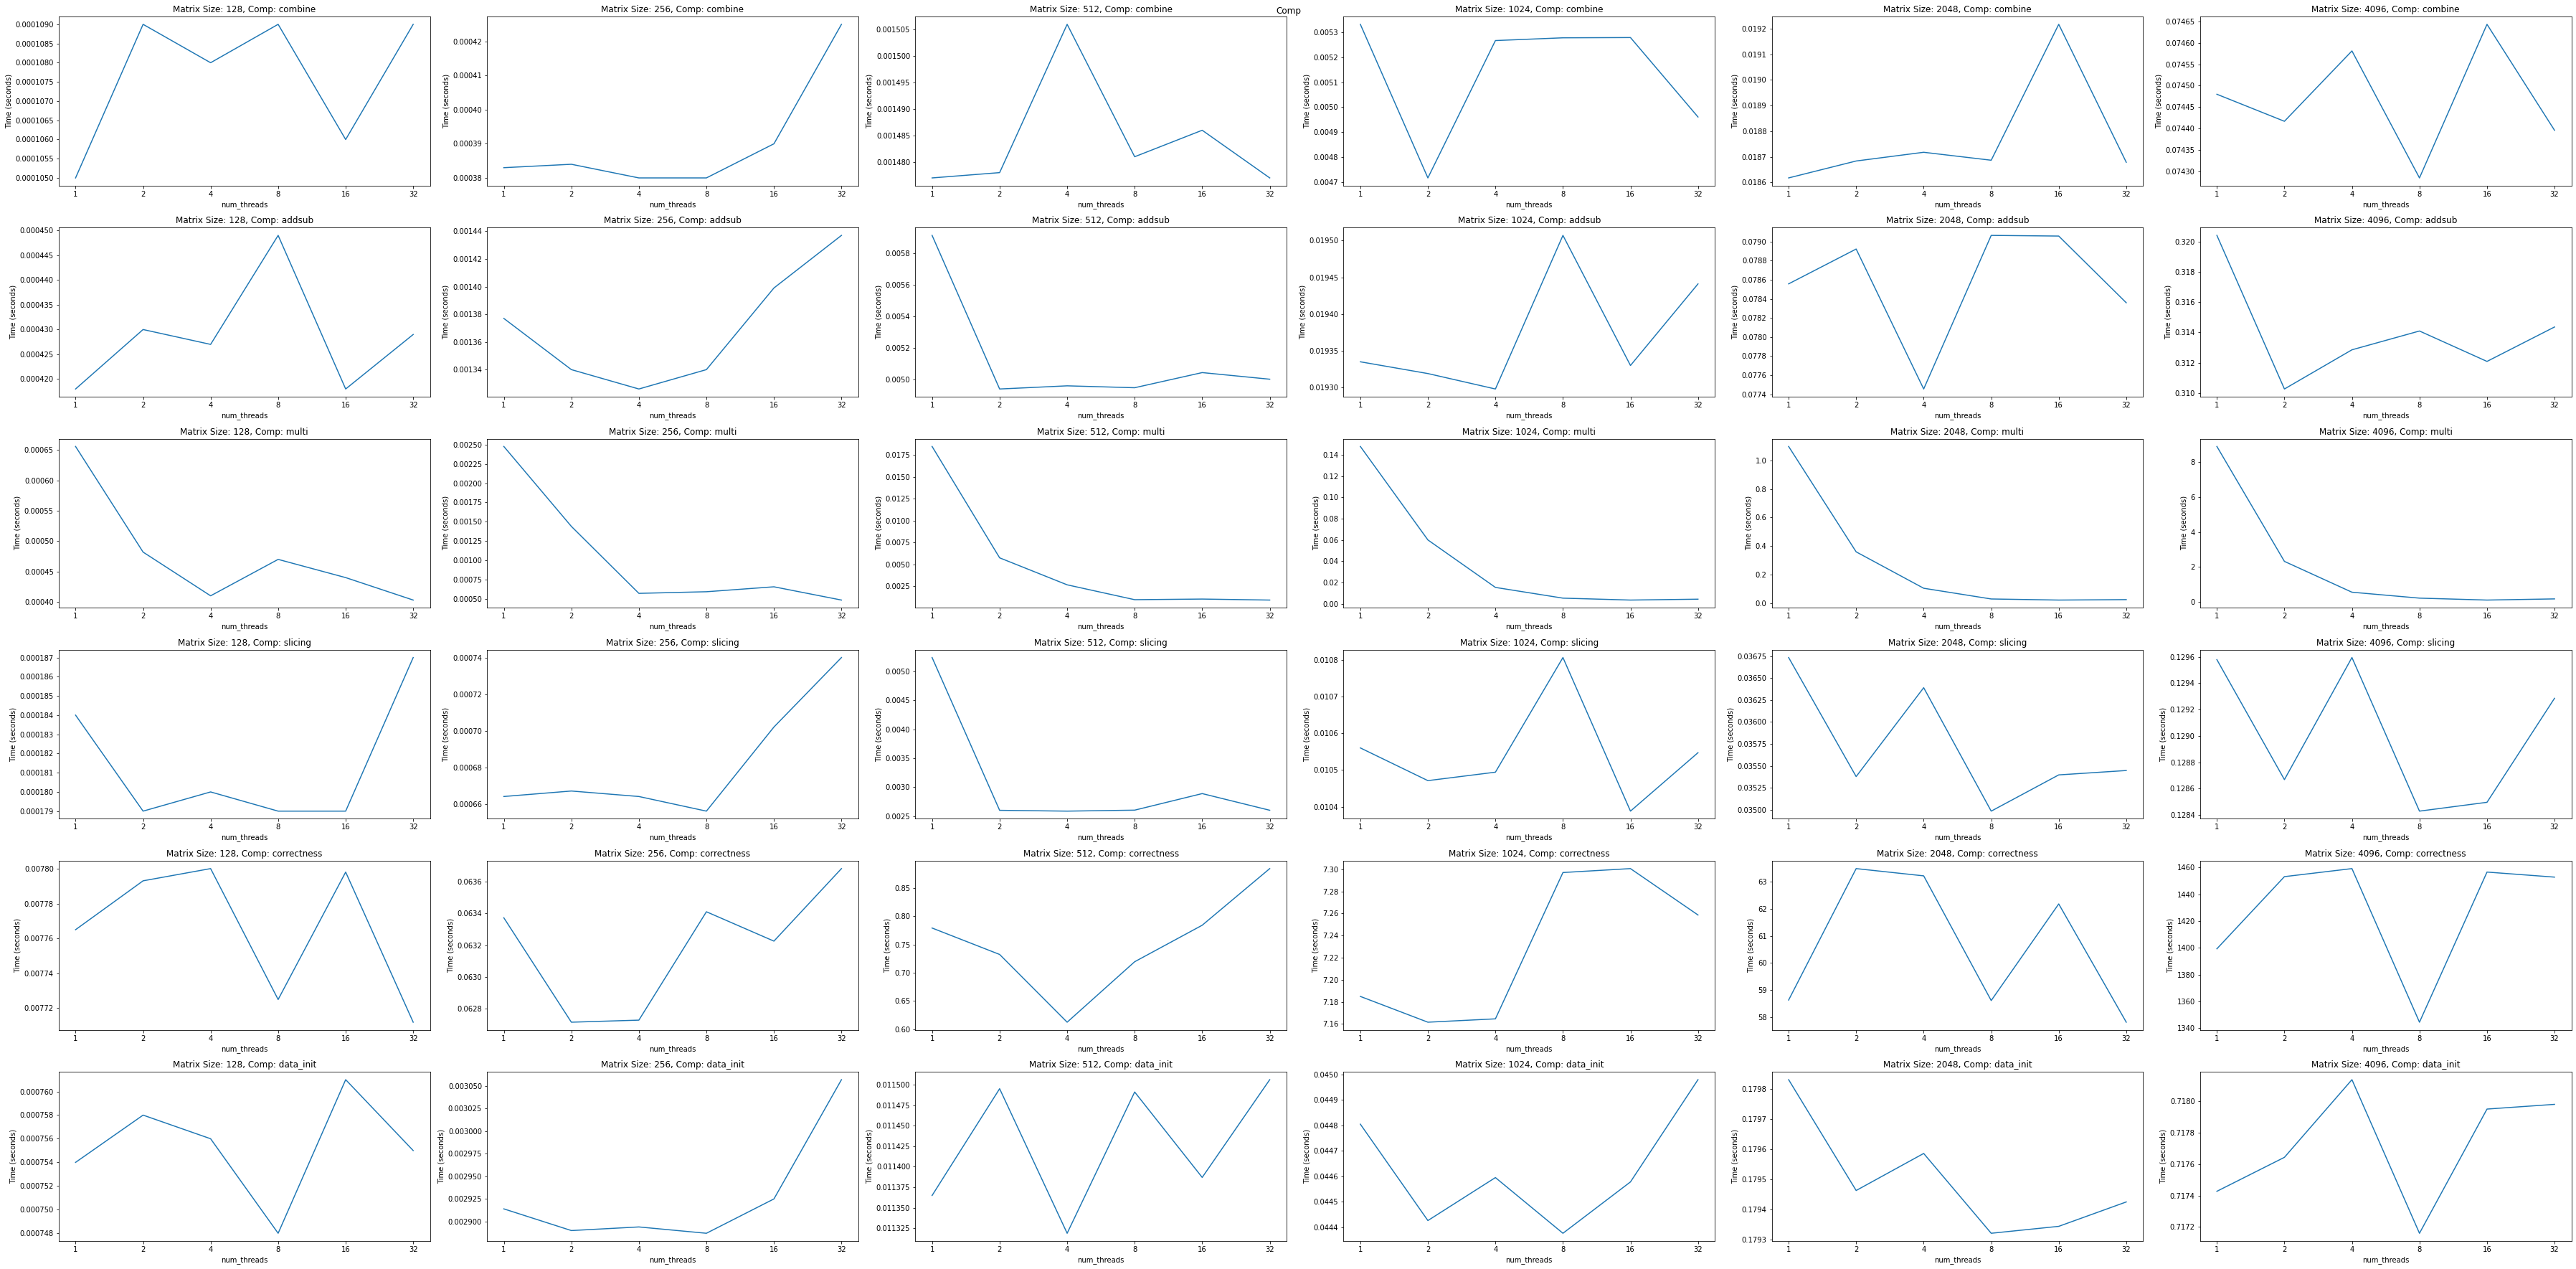

In [130]:
# print(ctk.dataframe.index)
# print(ctk.dataframe.columns)
df = ctk.dataframe
# Assuming your DataFrame is named 'df'
# Create or load your DataFrame
# df = ...

# Define the matrix sizes you want to plot
matrix_sizes = [128, 256, 512, 1024, 2048, 4096]

# Define the worker and master data series
# worker_data_series = ["worker_calculation", "worker_recieve", "worker_send"]
# master_data_series = ["whole_computation", "master_send_recieve", "master_initialization"]
comm = ["cudamemcpy"]
comp = ["cuda_naive_time", "correctness", "data_init"]


# Create subplots for worker data
fig, axs = plt.subplots(1, 6, figsize=(50, 5))
# fig.suptitle("Worker Data")
fig.suptitle("Comm")

# Create subplots for master data
fig2, axs2 = plt.subplots(3, 6, figsize=(50, 10))
# fig2.suptitle("Master Data")
fig2.suptitle("Comp")

# Loop through matrix sizes and data series
for i, matrix_size in enumerate(matrix_sizes):
    for j, data_series in enumerate(comm):
        ax = axs[i]
        data = df.loc[(data_series, matrix_size), :]
        data.index = data.index.droplevel(1)  # Remove the first level of the MultiIndex
        data.plot(ax=ax, title=f'Matrix Size: {matrix_size}, Comm: {data_series}')
        ax.set_xlabel("num_threads")
        ax.set_ylabel("Time (seconds)")

    for j, data_series in enumerate(comp):
        ax = axs2[j, i]
        data = df.loc[(data_series, matrix_size), :]
        data.index = data.index.droplevel(1)  # Remove the first level of the MultiIndex
        data.plot(ax=ax, title=f'Matrix Size: {matrix_size}, Comp: {data_series}')
        ax.set_xlabel("num_threads")
        ax.set_ylabel("Time (seconds)")

# Adjust the layout
plt.tight_layout()
plt.show()


In [50]:
# Define common variables
function_names = set(ctk.dataframe.index.get_level_values("name"))
threads = sorted(list(set(ctk.dataframe.index.get_level_values("num_procs"))))
matrix_sizes = sorted(ctk.dataframe.columns.tolist())

KeyError: 'Level num_procs not found'

# Plotting

### Option 1
Use `pandas.DataFrame.plot` to automatically interface with matplotlib

In [46]:
def plot_pandas(df, title, xlabel, ylabel, loglog):
    plot = df.plot(kind="line", 
        marker='o', 
        title=title, 
        xlabel=xlabel,
        ylabel=ylabel, 
        grid=True,
        loglog=loglog
    )
    return plot

### Option 2
Use `matplotlib.pyplot` directly for more fine-grained control. Specifically for our case we can change the x axis scaling from base 10 to base 2.

In [47]:
def plot_mpl(df, title, xlabel, ylabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(matrix_sizes)
    plt.grid(True)
    plt.yscale("log", base=10)
    plt.xscale("log", base=2)
    plt.xticks(threads)
    plt.show()
    return fig, ax

# Examples

## time

In [48]:
ctk.dataframe.loc["main"]

4                                           \
          Min time/rank Max time/rank Avg time/rank   Total time   
InputSize                                                          
128            0.392027      0.398540      0.393913     1.575651   
256            0.346411      0.400129      0.360285     1.441141   
512            0.500207      0.958925      0.615386     2.461545   
1024           1.937511      7.917518      3.432799    13.731198   
2048          16.257582     80.443053     32.304383   129.217530   
4096         328.697990   1675.564007    665.414500  2661.657998   

                                         8                              \
          Variance time/rank Min time/rank Max time/rank Avg time/rank   
InputSize                                                                
128                 0.000007      0.433096      0.440360      0.434221   
256                 0.000529      0.492410      0.554987      0.503490   
512                 0.039340      0.529886      1.233589      0.620466   
1024                6.704234      1.325889      7.550431      2.105368   
2048              772.443856      8.460777     69.807645     16.129681   
4096           340134.008948    179.716693   1563.045031    352.633664   

                                                     16                \
            Total time Variance time/rank Min time/rank Max time/rank   
InputSize                                                               
128           3.473769           0.000005      6.131866      9.241619   
256           4.027923           0.000395      0.508943      0.568770   
512           4.963731           0.053707      0.520784      1.136749   
1024         16.842943           4.235534      0.951594      6.832092   
2048        129.037449         411.617690      4.591423     65.259147   
4096       2821.069309      209299.382431     94.743396   1454.893124   

                                                                   32  \
          Avg time/rank   Total time Variance time/rank Min time/rank   
InputSize                                                               
128            7.685408   122.966527           2.398687      6.152744   
256            0.518767     8.300279           0.000184      0.574143   
512            0.564259     9.028137           0.021859      0.522779   
1024           1.323841    21.181450           2.022738      0.701745   
2048           8.386800   134.188794         215.630935      2.819830   
4096         179.756225  2876.099606      108398.274082     45.091347   

                                                                       \
          Max time/rank Avg time/rank   Total time Variance time/rank   
InputSize                                                               
128            9.262938      6.933099   221.859167           1.797111   
256            0.643461      0.589362    18.859579           0.000127   
512            1.005280      0.548887    17.564379           0.006770   
1024           7.764880      0.928738    29.719625           1.507534   
2048          66.892633      5.492441   175.758118         121.681125   
4096        1445.773181     88.866504  2843.728124       59393.410687   

                     64                                           \
          Min time/rank Max time/rank Avg time/rank   Total time   
InputSize                                                          
128            6.139745      9.087473      6.514431   416.923586   
256            3.180303      3.679889      3.591665   229.866588   
512            0.460709      1.103177      0.518809    33.203748   
1024          19.128636     29.219222     22.336157  1429.514063   
2048           2.269738     62.094665      3.961659   253.546177   
4096          23.617032   1422.557660     45.483347  2910.934204   

                                       128                              \
          Variance time/rank Min time/rank Max time/rank Avg time/rank   
InputSi

In [49]:
for name in function_names:
    plot_pandas(
        df=ctk.dataframe.loc[name],
        title=name,
        xlabel="Threads",
        ylabel="Time (seconds)",
        loglog=True
    )

NameError: name 'function_names' is not defined

In [ ]:
for name in function_names:
    plot_mpl(
        df=ctk.dataframe.loc[name],
        title=name,
        xlabel="num_procs",
        ylabel="Time (seconds)",
    )

## Speedup

In [ ]:
speedup_df = ctk.dataframe.loc[(slice(None),1), :].reset_index().drop("threads", axis=1).set_index("name")/ctk.dataframe

for name in function_names:
    plot_pandas(
        df=speedup_df.loc[name],
        title=f"{name}: thread-1/thread-N",
        xlabel="Threads",
        ylabel="Speedup",
        loglog=False
    )